In [28]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
input_shape = (224,224,3)

In [3]:
train_datasets_path = 'train2014/'
annotations_path = 'annotations/'

In [4]:
annotations_json_path = annotations_path + 'instances_train2014.json'
annotations_json = json.load(open(annotations_json_path,'r'))
annotations_json.keys()

dict_keys(['categories', 'info', 'annotations', 'licenses', 'images'])

In [18]:
def resize_by_padding(img,net_width,net_height,bbox):
    img_h,img_w = img.shape[:2]

    if img_h > img_w:
        new_h = int(net_height)
        new_w = int(img_w * net_height / img_h)
    else:
        new_w = int(net_width)
        new_h = int(img_h * net_width / img_w)

    bbox[0] *= new_w / img_w
    bbox[1] *= new_h / img_h
    bbox[2] *= new_w / img_w
    bbox[3] *= new_h / img_h
    
    img = img[:,:,::-1]
    img = img/255.
    resized = cv2.resize(img,(new_w,new_h))
    base_img = np.ones((net_height,net_width,3)) * 0.5
    base_img[(net_height-new_h)//2 : (net_height+new_h)//2,(net_width-new_w)//2 : (net_width+new_w)//2,:] = resized
    
    bbox[0] += (net_width-new_w)//2
    bbox[1] += (net_height-new_h)//2
    
    return base_img, bbox

In [6]:
def draw_box(img,bbox_ratio,color):
    x, y, w, h = bbox_ratio
    x1 = int(x*img.shape[1])
    y1 = int(y*img.shape[0])
    x2 = int((x+w)*img.shape[1])
    y2 = int((y+h)*img.shape[0])
    return cv2.rectangle(img,(x1,y1),(x2,y2),color,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17 dog


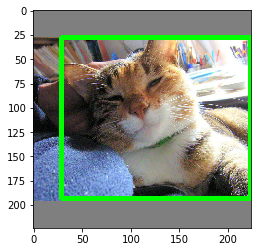

In [70]:
i = random.randrange(100000)
annotation = annotations_json['annotations'][i]
imgName = '{}COCO_train2014_{}.jpg'.format( train_datasets_path,str(annotation['image_id']).zfill(12) )

img = cv2.imread(imgName)

class_id = annotation['category_id']
bbox = annotation['bbox']

img, bbox = resize_by_padding(img,input_shape[1],input_shape[0],bbox)


x, y, w, h = [int(i) for i in bbox]


x /= img.shape[1]
y /= img.shape[0]
w /= img.shape[1]
h /= img.shape[0]

img = draw_box(img,[x,y,w,h],(0,255,0))

plt.imshow(img)
print(annotation['category_id'],annotations_json['categories'][annotation['category_id']-1]['name'])

In [54]:
img.dtype

dtype('float64')

In [21]:
annotation.keys()

dict_keys(['image_id', 'id', 'iscrowd', 'category_id', 'area', 'bbox', 'segmentation'])

In [24]:
annotations_json['annotations'][0].keys()

dict_keys(['category_id', 'id', 'iscrowd', 'segmentation', 'area', 'bbox', 'image_id'])

In [47]:
annotations_json['categories'][1-1]

{'id': 1, 'name': 'person', 'supercategory': 'person'}

SyntaxError: invalid syntax (<ipython-input-22-e8a84c92f1e6>, line 1)